In [1]:
from collections import defaultdict, Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pysam
from pyBioInfo.Range import GRange
from pyBioInfo.IO.File import BedFile
from pyBioInfo.Utils import ShiftLoader

In [2]:
def filter_blacklist_svs(svs, regions):
    svs1 = []
    loader = ShiftLoader(regions)
    for sv in svs:
        if len(list(loader.fetch(obj=sv))) == 0:
            svs1.append(sv)
    return svs1

def load_svs(f_vcf, f_tsv, f_bed=None):
    d = pd.read_csv(f_tsv, sep="\t")
    d = d[d["AgreeRead"] >= 5]
    if "NSS" in f_vcf:
        d = d[d["AgreeCell"] >= 3]
    d = d[(d["AgreeRead"] / (d["AgreeRead"] + d["DisagreeRead"])) >= 0.1]
    pass_names = set(d["Name"])

    svs = []
    with pysam.VariantFile(f_vcf) as f:
        for record in f:
            svtype = record.info["SVTYPE"]
            if svtype != "DEL" and svtype != "INS":
                continue
            if list(record.filter)[0] != "PASS":
                continue
            if record.id not in pass_names:
                continue
            sv = GRange(chrom=record.contig, start=record.start, end=record.stop, name=record.id)
            sv.length = abs(record.info["SVLEN"])
            svs.append(sv)
    svs.sort()
    
    if f_bed is not None:
        with BedFile(f_bed) as f:
            regions = [x for x in f]
            regions.sort()
            svs = filter_blacklist_svs(svs, regions)
            
    return svs

# Report number of SVs

In [5]:
names = ["PacBio", "Ultralong", "NSS"]
array = []
for name in names:
    f_vcf = "../../3_NanoStrandSeq_PseudoBulk/results/sv/filtered/%s.full.vcf.gz" % name
    f_tsv = "../../3_NanoStrandSeq_PseudoBulk/results/sv/quantify_lite/%s.full.tsv" % name
    svs = load_svs(f_vcf, f_tsv)
    array.append(svs)

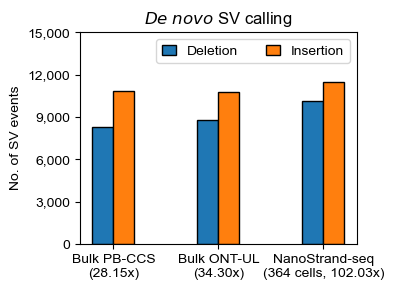

In [6]:
w = 0.2
xs = np.arange(3)
xs1 = xs - w / 2
xs2 = xs + w / 2
ys1 = [sum(["DEL" in sv.name for sv in svs]) for svs in array]
ys2 = [sum(["INS" in sv.name for sv in svs]) for svs in array]

plt.figure(figsize=(4, 3))
plt.title("$\it{De}$ $\it{novo}$ SV calling")
plt.bar(xs1, ys1, width=w, color="C0", edgecolor="black", label="Deletion")
plt.bar(xs2, ys2, width=w, color="C1", edgecolor="black", label="Insertion")
# plt.xlim(-0.5, 2.5)
plt.xticks(xs, ["Bulk PB-CCS\n(28.15x)", "Bulk ONT-UL\n(34.30x)", "NanoStrand-seq\n(364 cells, 102.03x)"])
plt.ylim(0, 15000)
ys = np.arange(0, 15000 + 1, 3000)
plt.yticks(ys, [format(y, ",") for y in ys])
plt.ylabel("No. of SV events")
plt.legend(handlelength=1, ncol=2)
plt.tight_layout()
plt.savefig("figures/sv_counts.pdf", dpi=300)

# SV length distribution


In [3]:
f_vcf = "../../3_NanoStrandSeq_PseudoBulk/results/sv/filtered/NSS.full.vcf.gz"
f_tsv = "../../3_NanoStrandSeq_PseudoBulk/results/sv/quantify_lite/NSS.full.tsv"  
svs = load_svs(f_vcf, f_tsv)
vs1 = [sv.length for sv in filter(lambda sv: "DEL" in sv.name, svs)]
vs2 = [sv.length for sv in filter(lambda sv: "INS" in sv.name, svs)]

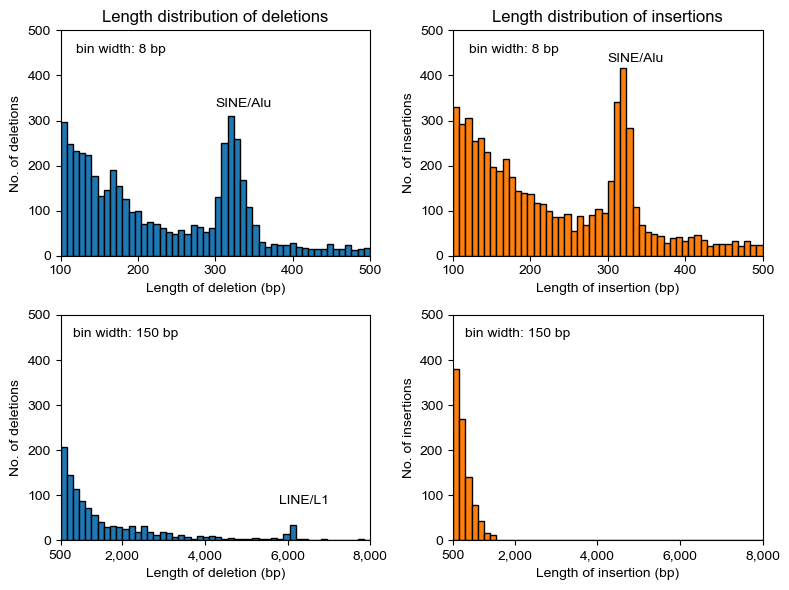

In [4]:
fig, axs = plt.subplots(2, 2, figsize=(8, 6))

ax = axs[0][0]
plt.sca(ax)
plt.hist(vs1, range=(100, 500), bins=50, edgecolor="black", color="C0")
plt.title("Length distribution of deletions")
plt.xlabel("Length of deletion (bp)")
plt.ylabel("No. of deletions")
plt.xlim(100, 500)
plt.ylim(0, 500)
plt.text(300, 330, "SINE/Alu")
plt.text(120, 450, "bin width: 8 bp")

ax = axs[1][0]
plt.sca(ax)
plt.hist(vs1, range=(500, 8000), bins=50, edgecolor="black", color="C0")
plt.xlabel("Length of deletion (bp)")
plt.ylabel("No. of deletions")
plt.ylim(0, 500)
plt.xlim(500, 8000)
plt.text(5800, 80, "LINE/L1")
xs = [500, 2000, 4000, 6000, 8000]
plt.xticks(xs, [format(x, ",") for x in xs])
plt.text(800, 450, "bin width: 150 bp")

ax = axs[0][1]
plt.sca(ax)
plt.hist(vs2, range=(100, 500), bins=50, edgecolor="black", color="C1")
plt.title("Length distribution of insertions")
plt.xlabel("Length of insertion (bp)")
plt.ylabel("No. of insertions")
plt.xlim(100, 500)
plt.ylim(0, 500)
plt.text(300, 430, "SINE/Alu")
plt.text(120, 450, "bin width: 8 bp")

ax = axs[1][1]
plt.sca(ax)
plt.hist(vs2, range=(500, 8000), bins=50, edgecolor="black", color="C1")
plt.xlabel("Length of insertion (bp)")
plt.ylabel("No. of insertions")
plt.xlim(500, 8000)
plt.ylim(0, 500)
xs = [500, 2000, 4000, 6000, 8000]
plt.xticks(xs, [format(x, ",") for x in xs])
plt.text(800, 450, "bin width: 150 bp")

plt.tight_layout()
plt.savefig("figures/sv_length_distribution.pdf", dpi=300)